# Generate the static augmentation using preprocess_augmentation.py

- The static augmentation are stored into a different HDF file. It follow the exact same architecture than the file containing the original audio.

- Each folds will contain as much dataset that there is augmentation generated. Each augmentation can be generated several time to allow the usage of different flavor, reducing the redundancy. Therefore the shape of the dataset is as follow (<nb_flavor>, <nb_file>, <raw_audio_length>)

- The number of flavor is extended automatically by one everytime the *standalone/preprocess_augmentation.py* is called with the same augmentation parameters. The list of augmentation that have a defined name can be found in *ubs8k/augmentation_list.py*

To generate this file, change the cell bellow as code and execute it. The entire process is quite long but need to be done only once.

<div class="alert alert-info">

**Estimated time to complete (5 CPU) is ~ 1h 30m**

**Estimated space needed is 27 Go**
</div>




%%bash
```bash
conda activate ubs8k
cd ../standalone

# N2, only one variante because it is determinist
python preprocess_augmentation.py -w 5 -A="signal_augmentations.Noise(1.0, target_snr=20)"

# PSC1 and PSC2, 4 variante
for i in 1 2 3 4;
do
    python preprocess_augmentation.py -w 5 -A="signal_augmentations.PitchShiftChoice(1.0, choice=(-3, -2, 2, 3))"
    python preprocess_augmentation.py -w 5 -A="signal_augmentations.PitchShiftChoice(1.0, choice=(-1.5, -1, 1, 1.5))",
done
```

# Testing StaticManager

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ubs8k.datasetManager import StaticManager
from ubs8k.datasetManager import DatasetManager

from ubs8k.generators import CoTrainingDataset

import ubs8k.signal_augmentations as sa

In [3]:
from pathlib import Path

metadata_root = Path("../dataset/metadata")
audio_root = Path("../dataset/audio")
static_aug_file = Path("../dataset/audio/urbansound8k_22050_augmentations.hdf5")

# metadata_root = Path("/mnt/e/Corpus/UrbanSound8K/metadata")
# audio_root = Path("/mnt/e/Corpus/UrbanSound8K/audio/")
# static_aug_file = Path("/mnt/e/Corpus/UrbanSound8K/audio/urbansound8k_22050_augmentations.hdf5")

classic_manager = DatasetManager(metadata_root, audio_root, train_fold=[1, 2, 3], val_fold=[], subsampling=0.1, subsampling_method="random", verbose=1)
static_manager = StaticManager(metadata_root, audio_root, train_fold=[1, 2, 3], val_fold=[], subsampling=0.1, subsampling_method="random", static_augment_file=static_aug_file)

 33%|███▎      | 1/3 [00:01<00:02,  1.06s/it]

filenames folds: 1:  ['57320-0-0-15.wav' '105415-2-0-15.wav' '139951-9-0-13.wav'
 '106905-8-0-2.wav' '102842-3-0-1.wav']
[160 581 484 480 831]
filenames folds: 2:  ['96920-9-0-3.wav' '27349-3-0-2.wav' '34621-4-26-0.wav'
 '152908-5-0-11.wav' '158597-2-0-3.wav']
[650 878  40 567 571]

 67%|██████▋   | 2/3 [00:02<00:01,  1.08s/it]


filenames folds: 3:  ['195451-5-0-8.wav' '33696-3-4-0.wav' '62837-7-1-18.wav'
 '22601-8-0-44.wav' '65750-3-0-5.wav']
[319 710 841 637 166]


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]
0it [00:00, ?it/s]
 33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]

filenames folds: 1:  ['57320-0-0-15.wav' '105415-2-0-15.wav' '139951-9-0-13.wav'
 '106905-8-0-2.wav' '102842-3-0-1.wav']
[160 581 484 480 831]
filenames folds: 2:  ['96920-9-0-3.wav' '27349-3-0-2.wav' '34621-4-26-0.wav'
 '152908-5-0-11.wav' '158597-2-0-3.wav']
[650 878  40 567 571]


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

filenames folds: 3:  ['195451-5-0-8.wav' '33696-3-4-0.wav' '62837-7-1-18.wav'
 '22601-8-0-44.wav' '65750-3-0-5.wav']
[319 710 841 637 166]



0it [00:00, ?it/s]


In [6]:
import h5py
with h5py.File(static_aug_file, "r") as hdf:
    for key in hdf["fold1"].keys():
        print("key: %s \t nb flavor: %s" % (key, hdf["fold1"][key].shape))

key: N 	 nb flavor: (4, 873, 88200)
key: N2 	 nb flavor: (1, 873, 88200)
key: PSC1 	 nb flavor: (4, 873, 88200)
key: PSC2 	 nb flavor: (4, 873, 88200)
key: filenames 	 nb flavor: (873,)


In [7]:
static_manager.add_augmentation("N")
# static_manager.add_augmentation("PSC2")

 67%|██████▋   | 2/3 [00:04<00:02,  2.33s/it]

filenames folds: 1:  ['57320-0-0-15.wav' '105415-2-0-15.wav' '139951-9-0-13.wav'
 '106905-8-0-2.wav' '102842-3-0-1.wav']
[160 581 484 480 831]
filenames folds: 2:  ['96920-9-0-3.wav' '27349-3-0-2.wav' '34621-4-26-0.wav'
 '152908-5-0-11.wav' '158597-2-0-3.wav']
[650 878  40 567 571]


100%|██████████| 3/3 [00:07<00:00,  2.44s/it]

filenames folds: 3:  ['195451-5-0-8.wav' '33696-3-4-0.wav' '62837-7-1-18.wav'
 '22601-8-0-44.wav' '65750-3-0-5.wav']
[319 710 841 637 166]
267
(4, 88200)


## check that names are in the same order

In [8]:
import numpy as np
with h5py.File(static_aug_file, "r") as hdf:
    static_filenames = np.asarray(list(hdf["fold1"]["filenames"]))
    
with h5py.File(audio_root / "urbansound8k_22050.hdf5", "r") as hdf:
    classic_filenames = np.asarray(list(hdf["fold1"]["filenames"]))

In [9]:
sum(static_filenames == classic_filenames)

873

# check the name correspond to same file (need listening)

In [10]:
key = "151977-0-0-12.wav"

with h5py.File(static_aug_file, "r") as hdf:
    filenames = hdf["fold1"]["filenames"][()]
    index = np.where(filenames == key)[0][0]
    static_raw = np.array(hdf["fold1"]["PSC1"][0][index])
    
with h5py.File(audio_root / "urbansound8k_22050.hdf5", "r") as hdf:
    filenames = hdf["fold1"]["filenames"][()]
    index = np.where(filenames == key)[0][0]
    classic_raw = np.array(hdf["fold1"]["data"][index])

In [11]:
display.display(Audio(classic_raw, rate=22050))
display.display(Audio(static_raw, rate=22050))

AttributeError: 'function' object has no attribute 'display'

# Test the features extracted by the classic and static dataset

## Test one fold, check mean and std

In [12]:
from IPython import display 
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
plt.style.use('dark_background')

In [13]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
            

In [30]:
from tqdm import trange
                                              
original_mean, original_std = [], []
static_mean, static_std = [], []
dynamic_mean, dynamic_std = [], []
augmentation="N"
static_augments = {augmentation: 1.0} # apply static PSC 1 all the time (flavor will be random)

In [31]:
classic_dataset = CoTrainingDataset(
    classic_manager, 1.0, # <-- all file are supervised. easier to gather all the files 1 by 1
    train=True, val=False,
    augments=[],
    S_augment=False, U_augment=False,
    cached=False
)

dynamic_dataset = CoTrainingDataset(
    classic_manager, 1.0,
    train=True, val=False,
#     augments=[sa.Noise(1.0, target_snr=20)], # N2
    augments=[sa.PitchShiftChoice(1.0, choice=(-1.5, -1.0, 1.0, 1.5))], # PSC 2
#     augments=[sa.PitchShiftChoice(1.0, choice=(-3, -2, 2, 3))], # PSC 1
    S_augment=True, U_augment=False,
    cached=False
)

static_dataset = CoTrainingDataset(
    static_manager, 1.0, # <-- all file are supervised. easier to gather all the files 1 by 1
    train=True, val=False,
    augments=[], static_augmentation=static_augments,
    S_augment=True, U_augment=False,
    cached=False
)

In [32]:
nb_classic_files = len(classic_dataset)
nb_static_files = len(static_dataset)

for i in trange(nb_classic_files):
    # create special indexing form for CoTrainingDataset (see samplers.py)
    index = [[i], [], []]  # [S1, S2, U]
    ((classic_s1, _, _), _) = classic_dataset[index] # return under the form ((s1, s2, u), y)
    ((dynamic_s1, _, _), _) = dynamic_dataset[index]
    ((static_s1, _, _), _) = static_dataset[index]
    
    original_mean.append(np.mean(classic_s1))
    original_std.append(np.std(classic_s1))

    dynamic_mean.append(np.mean(dynamic_s1))
    dynamic_std.append(np.std(dynamic_s1))
    
    static_mean.append(np.mean(static_s1))
    static_std.append(np.std(static_s1))

100%|██████████| 267/267 [00:32<00:00,  7.97it/s]


In [33]:
original_mean = np.asarray(original_mean)
original_std = np.asarray(original_std)

static_mean = np.asarray(static_mean)
static_std = np.asarray(static_std)

dynamic_mean = np.asarray(dynamic_mean)
dynamic_std = np.asarray(dynamic_std)

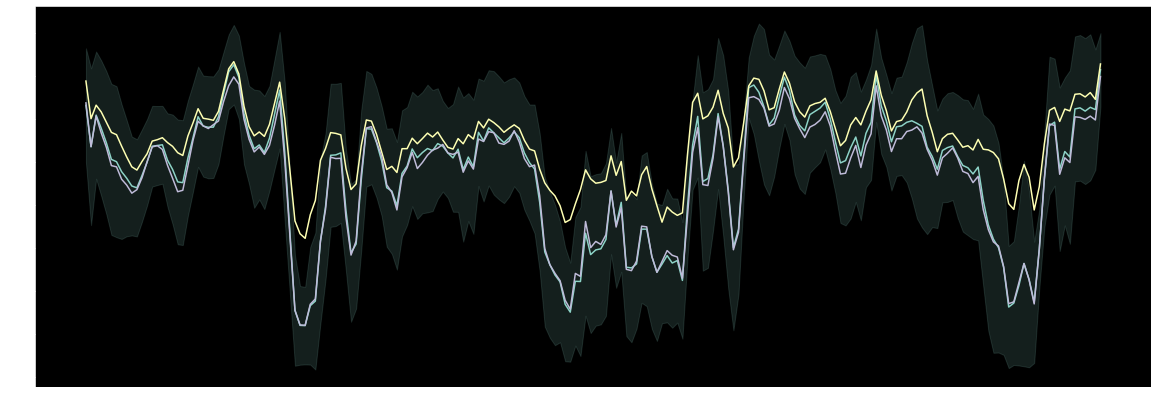

In [34]:
start=0
end=200
x = list(range(end-start))

display_ratio = 1
smooth_window = 3
om = smooth(original_mean[start:end], smooth_window)
ost = smooth(original_std[start:end] * display_ratio, smooth_window)

sm = smooth(static_mean[start:end], smooth_window)
sst = smooth(static_std[start:end] * display_ratio, smooth_window)

dm = smooth(dynamic_mean[start:end], smooth_window)
dst = smooth(dynamic_std[start:end] * display_ratio, smooth_window)

plt.figure(0, figsize=(20, 7))
plt.plot(x, om, color="C0")
plt.fill_between(x, om-ost, om+ost, color="C0", alpha=0.15)

plt.plot(x, sm, color="C1")
# plt.fill_between(x, sm-sst, sm+sst, color="C1", alpha=0.15)

plt.plot(x, dm, color="C2")
# plt.fill_between(x, dm-dst, dm+dst, color="C2", alpha=0.15)

plt.show()

## Check one file

In [40]:
index = 5
((classic_x, _, _), _) = classic_dataset[[[index], [], []]]
((static_x, _, _), _) = static_dataset[[[index], [], []]]
((dynamic_x, _, _), _) = dynamic_dataset[[[index], [], []]]

In [41]:
print(classic_x.dtype)
print(static_x.dtype)
print(dynamic_x.dtype)

float32
float32
float32


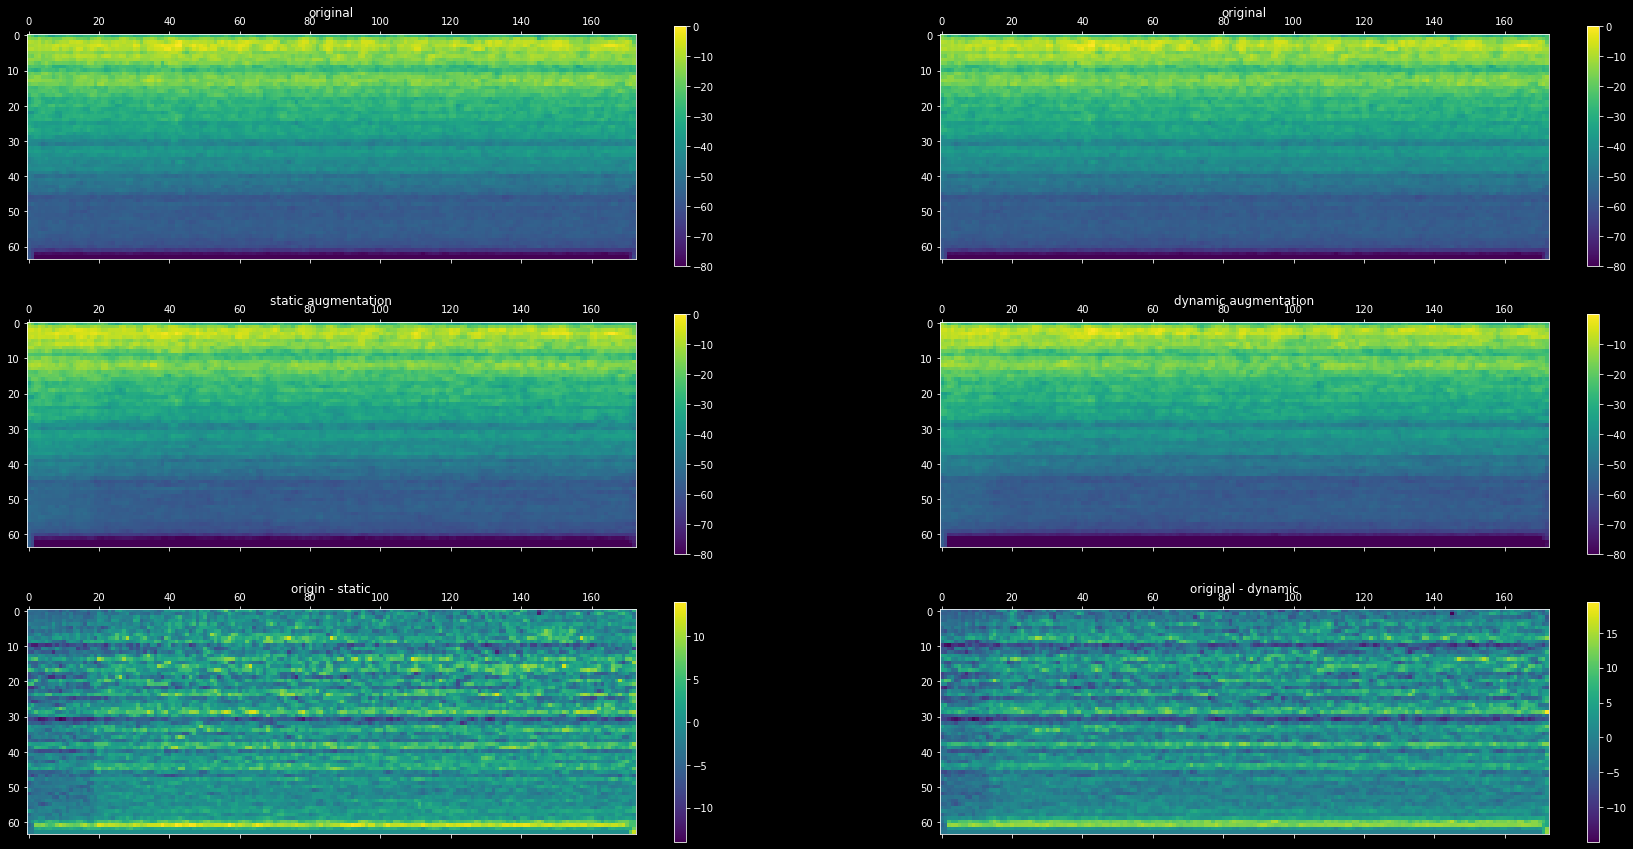

In [42]:
plt.figure(0, figsize=(30, 15))
plt.subplot(3, 2, 1)
plt.title("original")
plt.matshow(classic_x.squeeze(), fignum=0)
plt.colorbar()

plt.subplot(3, 2, 3)
plt.title("static augmentation")
plt.matshow(static_x.squeeze(), fignum=0)
plt.colorbar()

plt.subplot(3, 2, 5)
plt.title("origin - static")
plt.matshow(classic_x.squeeze() - static_x.squeeze(), fignum=0)
plt.colorbar()

# -------------
plt.subplot(3, 2, 2)
plt.title("original")
plt.matshow(classic_x.squeeze(), fignum=0)
plt.colorbar()

plt.subplot(3, 2, 4)
plt.title("dynamic augmentation")
plt.matshow(dynamic_x.squeeze(), fignum=0)
plt.colorbar()

plt.subplot(3, 2, 6)
plt.title("original - dynamic")
plt.matshow(classic_x.squeeze() - dynamic_x.squeeze(), fignum=0)
plt.colorbar()

plt.show()

# Check difference with file extracted from the manager

In [43]:
filenames = list(classic_manager.audio["train"].keys())

classic_raw = np.asarray([classic_manager.audio["train"][key] for key in filenames])
static_raw = np.asarray([static_manager.static_augmentation["train"][augmentation][key][0] for key in filenames])

In [44]:
index = 2
print(filenames[index])
display.display(Audio(classic_raw[index], rate=22050))
display.display(Audio(static_raw[index], rate=22050))

147764-4-4-1.wav


In [45]:
classic_raw.shape, static_raw.shape, classic_raw[0].dtype, static_raw[0].dtype

((267, 88200), (267, 88200), dtype('float64'), dtype('float32'))

In [46]:
classic_raw_mean = np.mean(classic_raw, axis=1)
classic_raw_std = np.std(classic_raw, axis=1)

static_raw_mean = np.mean(static_raw, axis=1)
static_raw_std = np.std(static_raw, axis=1)

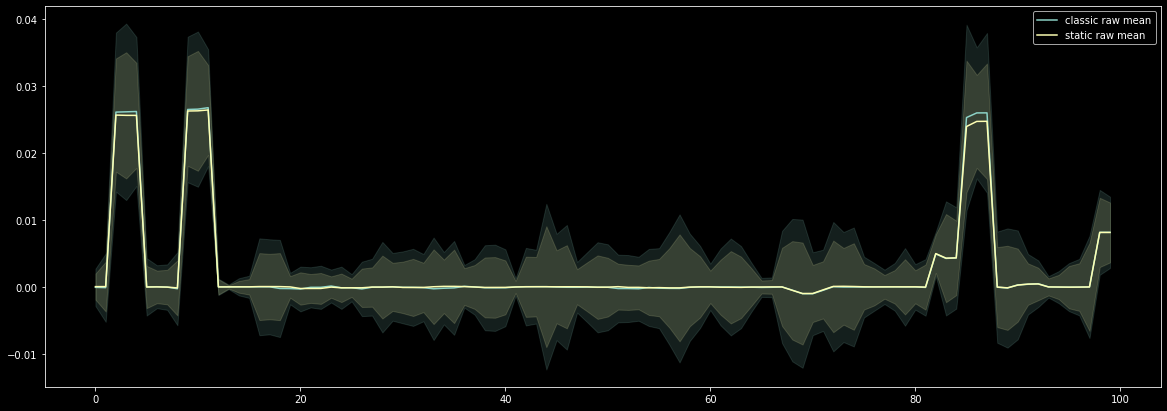

In [47]:
start=0
end=100
x = list(range(end-start))

display_ratio = 0.1
smooth_window = 3
om = smooth(classic_raw_mean[start:end], smooth_window)
ost = smooth(classic_raw_std[start:end] * display_ratio, smooth_window)
am1 = smooth(static_raw_mean[start:end], smooth_window)
ast1 = smooth(static_raw_std[start:end] * display_ratio, smooth_window)

plt.figure(0, figsize=(20, 7))
plt.plot(x, om, color="C0", label= "classic raw mean")
plt.fill_between(x, om-ost, om+ost, color="C0", alpha=0.15)

plt.plot(x, am1, color="C1", label="static raw mean")
plt.fill_between(x, am1-ast1, am1+ast1, color="C1", alpha=0.15)

plt.legend()
plt.show()

In [ ]:
python co-training_static_aug.py --model cnn -t 1 2 3 4 5 6 7 8 9 -v 10 --base_lr 0.01 --lambda_cot_max 5 --lambda_diff_max 0.25 --warm_up 160 --epsilon 0.1  --subsampling 0.1 --subsampling_method balance -T test  --log info --augment_S --static_augments="{'N2': 0.75}"